In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/bbc/business/059.txt', 'r') as f:
  contents = f.read()

contents

'Worldcom ex-boss launches defence\n\nLawyers defending former WorldCom chief Bernie Ebbers against a battery of fraud charges have called a company whistleblower as their first witness.\n\nCynthia Cooper, WorldCom\'s ex-head of internal accounting, alerted directors to irregular accounting practices at the US telecoms giant in 2002. Her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. Mr Ebbers has pleaded not guilty to charges of fraud and conspiracy.\n\nProsecution lawyers have argued that Mr Ebbers orchestrated a series of accounting tricks at WorldCom, ordering employees to hide expenses and inflate revenues to meet Wall Street earnings estimates. But Ms Cooper, who now runs her own consulting business, told a jury in New York on Wednesday that external auditors Arthur Andersen had approved WorldCom\'s accounting in early 2001 and 2002. She said Andersen had given a "green light" to the procedures and practices used by WorldCo

In [ ]:
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWODS = set(stopwords.words('english'))
import os
import glob
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
bbc_path = "/content/drive/My Drive/bbc/"

In [ ]:
def readFiles(path,clsId):
  fileNames = []
  fNames = []
  articles = []
  clsIds = []
  #print(glob.glob(path+"*.txt"))
  filenames=os.listdir(path)
  
  for ef in filenames:
    f = open(path+ef).readlines()
    articles.append(" ".join(f))
    clsIds.append(clsId)
    fNames.append(ef)
  
  return fNames,articles,clsIds
  

In [ ]:
classNames = ["business","entertainment","politics","sport","tech"]
allArticles = []
allClsIds = []
allFileNames = []
for idx in range(len(classNames)):
  p = bbc_path+classNames[idx]+"/"
  fn,ad,cid = readFiles(p,classNames[idx])
  allArticles = allArticles + ad
  allClsIds = allClsIds + cid
  allFileNames = allFileNames + fn
 
print(len(allArticles),len(allClsIds),len(allFileNames))

2225 2225 2225


In [ ]:
#df with count vectorizer
cols = ['article', 'labels']
d = {'article':allArticles, 'labels':allClsIds}
df = pd.DataFrame(data=d, columns=cols)
df.head()

,article,labels
0,VW considers opening Indian plant\n \n Volkswa...,business
1,Saudi ministry to employ women\n \n Women will...,business
2,Boeing secures giant Japan order\n \n Boeing i...,business
3,House prices drop as sales slow\n \n House pri...,business
4,Christmas shoppers flock to tills\n \n Shops a...,business


In [ ]:
df.shape

(2225, 2)

In [ ]:
df.dtypes

article    object
labels     object
dtype: object

In [ ]:
df.labels.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: labels, dtype: int64

In [ ]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['article'] = df['article'].apply(clean_text)
df['article'] = df['article'].str.replace('\d+', '')

<ipython-input-51-474e3429b295>:20: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df.article.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 31285 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['article'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2225, 250)


In [ ]:
Y = pd.get_dummies(df['labels']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2225, 5)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2002, 250) (2002, 5)
(223, 250) (223, 5)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
29/29 [==============================] - 32s 1s/step - loss: 1.5899 - accuracy: 0.2937 - val_loss: 1.5161 - val_accuracy: 0.4826
Epoch 2/5
29/29 [==============================] - 28s 953ms/step - loss: 1.1039 - accuracy: 0.5897 - val_loss: 0.7966 - val_accuracy: 0.7114
Epoch 3/5
29/29 [==============================] - 29s 1s/step - loss: 0.5689 - accuracy: 0.8506 - val_loss: 0.4349 - val_accuracy: 0.8706
Epoch 4/5
29/29 [==============================] - 29s 1s/step - loss: 0.2028 - accuracy: 0.9584 - val_loss: 0.4396 - val_accuracy: 0.8955
Epoch 5/5
29/29 [==============================] - 28s 953ms/step - loss: 0.2320 - accuracy: 0.9411 - val_loss: 0.4145 - val_accuracy: 0.8507


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7/7 [==============================] - 0s 66ms/step - loss: 0.3980 - accuracy: 0.8386
Test set
  Loss: 0.398
  Accuracy: 0.839


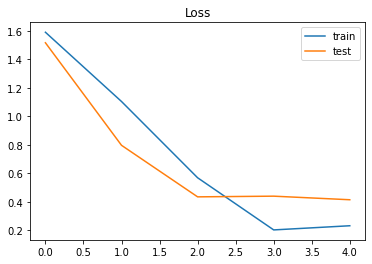

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
new_complaint = ['en a "green light" to the procedures and practices used by WorldCom. Mr Ebber\'s lawyers have said he was unaware of the fraud, arguing that auditors did not alert him to any problems.\n\nMs Cooper also said that during shareholder meetings Mr Ebbers often passed over technical questions to the company\'s finance chief, giving only "brief" answers himself. The prosecution\'s star witness, former WorldCom financial chief Scott Sullivan, has said that Mr Ebbers ordered accounting adjustments at the firm, telling him to "hit our books". However, Ms Cooper said Mr Sullivan had not mentioned "anything uncomfortable" about WorldCom\'s accounting during a 2001 audit committee meeting. Mr Ebbers could face a jail sentence of 85 years if convicted of all the charges he is facing. WorldCom emerged from bankruptcy protection in 2004, and is now known as MCI. Last week, MCI agreed to a buyout by Verizon Communications in a ']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ["business","entertainment","politics","sport","tech"]
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 72ms/step
[[0.722311   0.00536117 0.22058612 0.04589064 0.0058511 ]] business
